# Delays prediction - machine learning models (regression)

Katarzyna Mocio 429956 
Marcin Miszkiel 432418

# 1. Prepare necessary libraries

In [62]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option("display.max_columns",100)

# Data wrangling
import numpy as np
from datetime import datetime as dt 

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# Modelling with scikit-learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import optuna
import sklearn



Delays for regression
Your task is to apply various ML algorithms (see the rules below) to build a model explaining the delays of the flights based on the training sample and generate predictions for all observations from the test sample.

The dataset includes 1631327 observations in the training sample and 407832 in the test sample and the following columns:

Weekday – Day of the week when the flight occurred (1 for Sunday, 7 for Saturday).
Month_of_Year – The numerical month (1-12) when the flight took place.
Day_of_Month – The day of the month (1-31) when the flight occurred.
Scheduled_Departure_Time – The scheduled local time of flight departure.
Scheduled_Arrival_Time – The scheduled local time of flight arrival.
Marketing_Airline – The airline code under which the flight was marketed.
Marketing_Airline_DOT_ID – Department of Transportation identifier for the marketing airline.
Flight_Number – The number assigned to the flight by the operating airline.
Origin_Airport_ID – Unique identifier for the departure airport.
Destination_Airport_ID – Unique identifier for the arrival airport.
Flight_Cancelled – Indicator of whether the flight was cancelled (1 = Yes, 0 = No).
Departure_State – The state code of the departure location.
Arrival_State – The state code of the arrival location.
Departure_Delay – Total delay in minutes at departure.
Diverted_Airport_Landings – Count of unplanned landings at other airports.
Taxi_Out_Time – Time in minutes from gate departure until takeoff.
Taxi_In_Time – Time in minutes from landing to gate arrival.
Flight_Diverted – Indicator of whether the flight was diverted (1 = Yes, 0 = No).
Actual_Departure_Time – The actual local time the flight departed.
Flight_Duration – The duration of the flight in minutes from takeoff to landing.
Flight_Distance – The total distance covered by the flight in miles.
Origin_Temperature – The temperature at the origin airport at the time of the flight’s departure.
Destination_Temperature – The temperature at the destination airport at the time of the flight’s arrival.
Origin_Wind_Speed – The wind speed at the origin airport during the departure of the flight.
Destination_Wind_Speed – The wind speed at the destination airport during the departure of the flight.
Origin_Precipitation – The amount of precipitation, such as rain or snow, at the origin airport around the flight’s departure time.
Destination_Precipitation – The amount of precipitation, such as rain or snow, at the destination airport around the flight’s arrival time.
Arrival_Delay – Total delay in minutes at arrival (outcome variable, only in the training sample)

Let's load the data and look at the first five observations

In [63]:
delays = pd.read_csv('delays_train.csv')

delays.head()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,Departure_State,Arrival_State,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
0,6,6,25,1222,1444,B6,20409,520,10397,12478.00,False,GA,NY,NaN,NaN,0,16.00,10.00,False,1224.00,107.00,760.00,25.14,19.36,21.02,15.45,0.00,0.00
1,2,6,21,1216,1304,NaN,19805,6297,14107,15376.00,False,AZ,AZ,0.09,-4.18,0,16.00,5.00,False,1216.00,23.00,110.00,13.28,20.47,18.05,12.91,0.00,0.00
2,3,1,5,1945,2055,DL,19790,4124,13487,13076.00,False,MN,WI,NaN,5.04,0,34.00,5.00,False,1945.00,36.00,119.00,17.82,13.97,21.61,17.98,0.00,0.10
3,2,3,22,700,924,AA,19805,1538,15624,11298.00,False,FL,TX,-1.80,-0.21,0,10.00,11.00,False,658.00,125.00,641.00,24.56,14.51,24.95,22.63,0.00,0.00
4,4,7,14,2130,2359,NaN,19930,1116,14747,12889.00,False,WA,NV,NaN,14.01,0,23.00,7.00,False,2133.00,130.00,867.00,8.82,10.87,17.43,17.40,0.00,0.00


In [64]:
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1467776 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1468233 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [65]:
an = pd.read_csv('airline_name.csv', index_col=False)
an = an.set_index('id')['name'].to_dict()
delays['Marketing_Airline'] = delays['Marketing_Airline_DOT_ID'].map(an)
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1631327 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1468233 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [66]:
grouped = delays.groupby(['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time'])
value_counts_dest_id = grouped['Marketing_Airline'].value_counts()
airportD = value_counts_dest_id.reset_index()
airportD.columns = ['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Count']

delays['key'] = delays['Marketing_Airline'] + '_' + delays['Flight_Number'].astype(str) + '_' + delays['Origin_Airport_ID'].astype(str) + '_' + delays['Weekday'].astype(str) + '_' + delays['Scheduled_Departure_Time'].astype(str) + '_' + delays['Scheduled_Arrival_Time'].astype(str)
airportD['key'] = airportD['Marketing_Airline'] + '_' + airportD['Flight_Number'].astype(str) + '_' + airportD['Origin_Airport_ID'].astype(str) + '_' + airportD['Weekday'].astype(str) + '_' + airportD['Scheduled_Departure_Time'].astype(str) + '_' + airportD['Scheduled_Arrival_Time'].astype(str)
                                                                                                                                                                                                                                                                                                   
map_dict = airportD.set_index('key')['Destination_Airport_ID'].to_dict()
delays['Destination_Airport_ID'] = delays['Destination_Airport_ID'].fillna(delays['key'].map(map_dict))
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1631327 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1592493 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [67]:
grouped = delays.groupby(['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Taxi_In_Time'])
value_counts_dest_id = grouped['Marketing_Airline'].value_counts()
airportD = value_counts_dest_id.reset_index()
airportD.columns = ['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Taxi_In_Time', 'Count']

delays['key'] = delays['Marketing_Airline'] + '_' + delays['Flight_Number'].astype(str) + '_' + delays['Origin_Airport_ID'].astype(str) + '_' + delays['Destination_Airport_ID'].astype(str) + '_' + delays['Weekday'].astype(str) + '_' + delays['Scheduled_Departure_Time'].astype(str) + '_' + delays['Scheduled_Arrival_Time'].astype(str)
airportD['key'] = airportD['Marketing_Airline'] + '_' + airportD['Flight_Number'].astype(str) + '_' + airportD['Origin_Airport_ID'].astype(str) + '_' + airportD['Destination_Airport_ID'].astype(str) + '_' + airportD['Weekday'].astype(str) + '_' + airportD['Scheduled_Departure_Time'].astype(str) + '_' + airportD['Scheduled_Arrival_Time'].astype(str)
                                                                                                                                                                                                                                                                                                   
map_dict = airportD.set_index('key')['Taxi_In_Time'].to_dict()
delays['Taxi_In_Time'] = delays['Taxi_In_Time'].fillna(delays['key'].map(map_dict))
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1631327 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1592493 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [68]:
grouped = delays.groupby(['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Taxi_Out_Time'])
value_counts_dest_id = grouped['Marketing_Airline'].value_counts()
airportD = value_counts_dest_id.reset_index()
airportD.columns = ['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Taxi_Out_Time', 'Count']

delays['key'] = delays['Marketing_Airline'] + '_' + delays['Flight_Number'].astype(str) + '_' + delays['Origin_Airport_ID'].astype(str) + '_' + delays['Destination_Airport_ID'].astype(str) + '_' + delays['Weekday'].astype(str) + '_' + delays['Scheduled_Departure_Time'].astype(str) + '_' + delays['Scheduled_Arrival_Time'].astype(str)
airportD['key'] = airportD['Marketing_Airline'] + '_' + airportD['Flight_Number'].astype(str) + '_' + airportD['Origin_Airport_ID'].astype(str) + '_' + airportD['Destination_Airport_ID'].astype(str) + '_' + airportD['Weekday'].astype(str) + '_' + airportD['Scheduled_Departure_Time'].astype(str) + '_' + airportD['Scheduled_Arrival_Time'].astype(str)
                                                                                                                                                                                                                                                                                                   
map_dict = airportD.set_index('key')['Taxi_Out_Time'].to_dict()
delays['Taxi_Out_Time'] = delays['Taxi_Out_Time'].fillna(delays['key'].map(map_dict))
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1631327 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1592493 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [69]:
grouped = delays.groupby(['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Flight_Duration'])
value_counts_dest_id = grouped['Marketing_Airline'].value_counts()
airportD = value_counts_dest_id.reset_index()
airportD.columns = ['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Flight_Duration', 'Count']

delays['key'] = delays['Marketing_Airline'] + '_' + delays['Flight_Number'].astype(str) + '_' + delays['Origin_Airport_ID'].astype(str) + '_' + delays['Destination_Airport_ID'].astype(str) + '_' + delays['Weekday'].astype(str) + '_' + delays['Scheduled_Departure_Time'].astype(str) + '_' + delays['Scheduled_Arrival_Time'].astype(str)
airportD['key'] = airportD['Marketing_Airline'] + '_' + airportD['Flight_Number'].astype(str) + '_' + airportD['Origin_Airport_ID'].astype(str) + '_' + airportD['Destination_Airport_ID'].astype(str) + '_' + airportD['Weekday'].astype(str) + '_' + airportD['Scheduled_Departure_Time'].astype(str) + '_' + airportD['Scheduled_Arrival_Time'].astype(str)
                                                                                                                                                                                                                                                                                                   
map_dict = airportD.set_index('key')['Flight_Duration'].to_dict()
delays['Flight_Duration'] = delays['Flight_Duration'].fillna(delays['key'].map(map_dict))
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1631327 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1592493 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [70]:
grouped = delays.groupby(['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Flight_Distance'])
value_counts_dest_id = grouped['Marketing_Airline'].value_counts()
airportD = value_counts_dest_id.reset_index()
airportD.columns = ['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Flight_Distance', 'Count']

delays['key'] = delays['Marketing_Airline'] + '_' + delays['Flight_Number'].astype(str) + '_' + delays['Origin_Airport_ID'].astype(str) + '_' + delays['Destination_Airport_ID'].astype(str) + '_' + delays['Weekday'].astype(str) + '_' + delays['Scheduled_Departure_Time'].astype(str) + '_' + delays['Scheduled_Arrival_Time'].astype(str)
airportD['key'] = airportD['Marketing_Airline'] + '_' + airportD['Flight_Number'].astype(str) + '_' + airportD['Origin_Airport_ID'].astype(str) + '_' + airportD['Destination_Airport_ID'].astype(str) + '_' + airportD['Weekday'].astype(str) + '_' + airportD['Scheduled_Departure_Time'].astype(str) + '_' + airportD['Scheduled_Arrival_Time'].astype(str)
                                                                                                                                                                                                                                                                                                   
map_dict = airportD.set_index('key')['Flight_Distance'].to_dict()
delays['Flight_Distance'] = delays['Flight_Distance'].fillna(delays['key'].map(map_dict))
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1631327 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1592493 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [71]:
cols = ['Origin_Temperature', 'Destination_Temperature', 'Origin_Wind_Speed', 'Destination_Wind_Speed']
for col in cols:
    mode = delays[col].mode()[0]
    delays[col] = delays[col].fillna(mode)
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1631327 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1592493 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [72]:
delays = delays[delays['Flight_Cancelled'] == False]
delays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1581877 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1581877 non-null  int64  
 1   Month_of_Year              1581877 non-null  int64  
 2   Day_of_Month               1581877 non-null  int64  
 3   Scheduled_Departure_Time   1581877 non-null  int64  
 4   Scheduled_Arrival_Time     1581877 non-null  int64  
 5   Marketing_Airline          1581877 non-null  object 
 6   Marketing_Airline_DOT_ID   1581877 non-null  int64  
 7   Flight_Number              1581877 non-null  int64  
 8   Origin_Airport_ID          1581877 non-null  int64  
 9   Destination_Airport_ID     1544540 non-null  float64
 10  Flight_Cancelled           1581877 non-null  bool   
 11  Departure_State            1581877 non-null  object 
 12  Arrival_State              1581877 non-null  object 
 13  Departure_Delay  

In [73]:
delays['Scheduled_Departure_Time'] = delays['Scheduled_Departure_Time'].astype(str).str.zfill(4)
delays['Actual_Departure_Time'] = delays['Actual_Departure_Time'].astype(int).astype(str).str.zfill(4)

delays['sh_h'] = delays['Scheduled_Departure_Time'].str.slice(start=0, stop=2)
delays['sh_min'] = delays['Scheduled_Departure_Time'].str.slice(start=2, stop=4)
delays['loc_h'] = delays['Actual_Departure_Time'].str.slice(start=0, stop=2)
delays['loc_min'] = delays['Actual_Departure_Time'].str.slice(start=2, stop=4)

delays[['sh_h', 'sh_min', 'loc_h', 'loc_min']] = delays[['sh_h', 'sh_min', 'loc_h', 'loc_min']].astype(int)
delays['calculated_delay'] = (delays['loc_h'] - delays['sh_h']) * 60 + (delays['loc_min'] - delays['sh_min'])
delays['Departure_Delay'] = delays['Departure_Delay'].fillna(delays['calculated_delay'])

delays = delays.drop(['sh_h', 'sh_min', 'loc_h', 'loc_min','calculated_delay'], axis =1)
delays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1581877 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1581877 non-null  int64  
 1   Month_of_Year              1581877 non-null  int64  
 2   Day_of_Month               1581877 non-null  int64  
 3   Scheduled_Departure_Time   1581877 non-null  object 
 4   Scheduled_Arrival_Time     1581877 non-null  int64  
 5   Marketing_Airline          1581877 non-null  object 
 6   Marketing_Airline_DOT_ID   1581877 non-null  int64  
 7   Flight_Number              1581877 non-null  int64  
 8   Origin_Airport_ID          1581877 non-null  int64  
 9   Destination_Airport_ID     1544540 non-null  float64
 10  Flight_Cancelled           1581877 non-null  bool   
 11  Departure_State            1581877 non-null  object 
 12  Arrival_State              1581877 non-null  object 
 13  Departure_Delay  

In [74]:
delays = delays[delays['Arrival_Delay'].notnull()]
delays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1420021 entries, 1 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1420021 non-null  int64  
 1   Month_of_Year              1420021 non-null  int64  
 2   Day_of_Month               1420021 non-null  int64  
 3   Scheduled_Departure_Time   1420021 non-null  object 
 4   Scheduled_Arrival_Time     1420021 non-null  int64  
 5   Marketing_Airline          1420021 non-null  object 
 6   Marketing_Airline_DOT_ID   1420021 non-null  int64  
 7   Flight_Number              1420021 non-null  int64  
 8   Origin_Airport_ID          1420021 non-null  int64  
 9   Destination_Airport_ID     1386412 non-null  float64
 10  Flight_Cancelled           1420021 non-null  bool   
 11  Departure_State            1420021 non-null  object 
 12  Arrival_State              1420021 non-null  object 
 13  Departure_Delay  

In [75]:
delays['Scheduled_Departure_Time'] = delays['Scheduled_Departure_Time'].astype('int64')
delays['Actual_Departure_Time'] = delays['Actual_Departure_Time'].astype('int64')
delays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1420021 entries, 1 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1420021 non-null  int64  
 1   Month_of_Year              1420021 non-null  int64  
 2   Day_of_Month               1420021 non-null  int64  
 3   Scheduled_Departure_Time   1420021 non-null  int64  
 4   Scheduled_Arrival_Time     1420021 non-null  int64  
 5   Marketing_Airline          1420021 non-null  object 
 6   Marketing_Airline_DOT_ID   1420021 non-null  int64  
 7   Flight_Number              1420021 non-null  int64  
 8   Origin_Airport_ID          1420021 non-null  int64  
 9   Destination_Airport_ID     1386412 non-null  float64
 10  Flight_Cancelled           1420021 non-null  bool   
 11  Departure_State            1420021 non-null  object 
 12  Arrival_State              1420021 non-null  object 
 13  Departure_Delay  

In [76]:
pd.set_option('display.float_format', '{:.2f}'.format)
delays.describe()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
count,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1386412.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1384837.00,1386207.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00
mean,4.00,4.11,15.78,1328.28,1484.47,19829.66,2554.66,12664.50,12663.54,12.24,7.50,0.00,16.95,7.89,1334.12,111.19,798.66,18.94,18.94,18.24,18.27,0.10,0.11
std,2.01,1.99,8.73,489.84,518.15,275.88,1742.12,1524.14,1523.96,59.45,55.62,0.00,9.47,6.65,505.69,70.07,593.12,8.55,8.55,6.86,6.79,0.34,0.34
min,1.00,1.00,1.00,1.00,1.00,19393.00,1.00,10135.00,10135.00,-1438.00,-100.04,0.00,1.00,1.00,1.00,8.00,31.00,-7.81,-6.43,1.72,1.99,0.00,0.00
25%,2.00,2.00,8.00,913.00,1102.00,19790.00,1104.00,11292.00,11292.00,-5.06,-14.42,0.00,11.00,4.00,916.00,60.00,366.00,13.56,13.57,15.93,15.94,0.00,0.00
50%,4.00,4.00,16.00,1320.00,1510.00,19805.00,2223.00,12889.00,12889.00,-1.63,-5.11,0.00,15.00,6.00,1325.00,94.00,642.00,17.30,17.30,19.28,19.28,0.00,0.00
75%,6.00,6.00,23.00,1733.00,1919.00,19977.00,3860.00,14027.00,14027.00,10.31,10.18,0.00,19.00,9.00,1744.00,141.00,1035.00,21.57,21.57,22.46,22.47,0.00,0.00
max,7.00,7.00,31.00,2359.00,2359.00,20436.00,9680.00,16869.00,16869.00,7223.21,7232.23,0.00,221.00,280.00,2400.00,675.00,5095.00,40.00,40.00,42.58,42.77,2.00,2.00


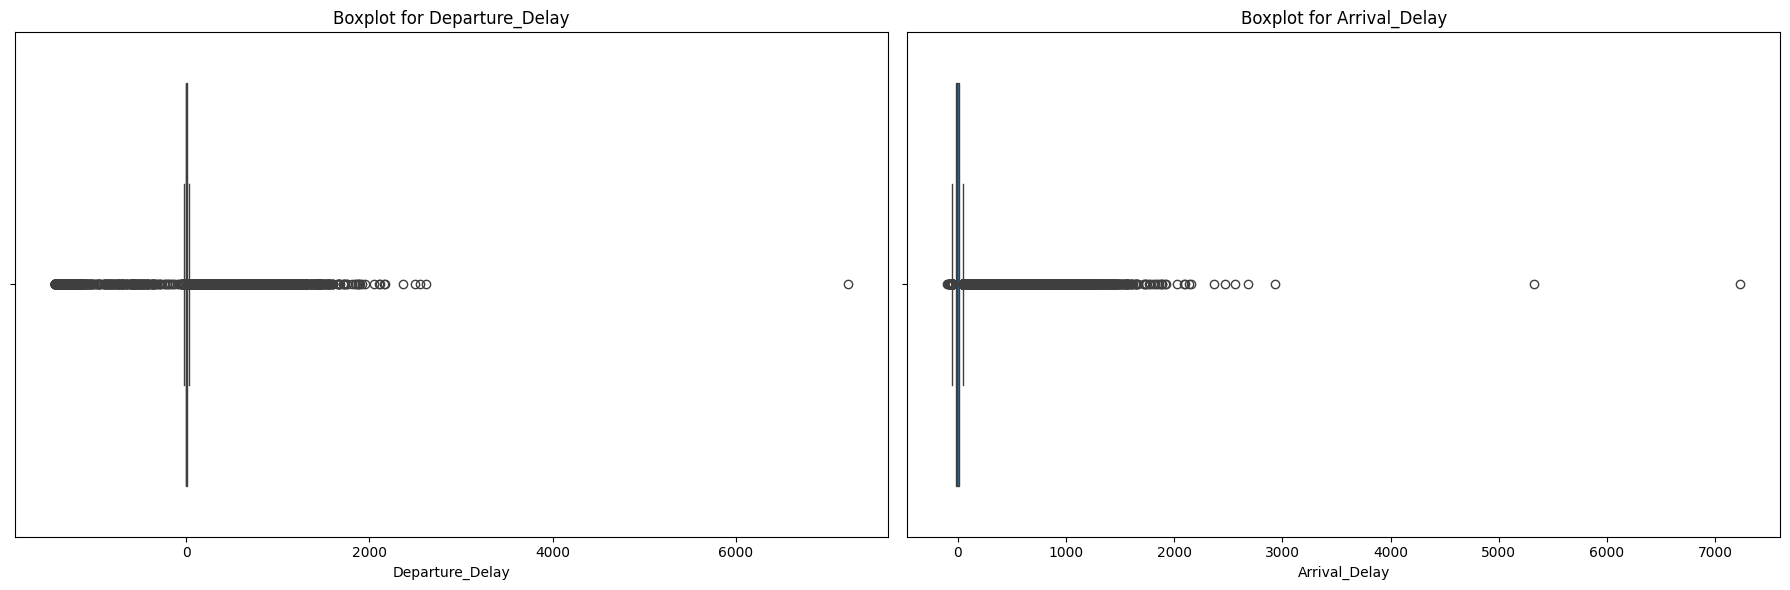

In [77]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=delays['Departure_Delay'])
plt.title('Boxplot for Departure_Delay')
plt.xlabel('Departure_Delay')

plt.subplot(1, 2, 2)
sns.boxplot(x=delays['Arrival_Delay'])
plt.title('Boxplot for Arrival_Delay')
plt.xlabel('Arrival_Delay')

plt.tight_layout()
plt.show()


In [78]:
value_counts = delays['Departure_Delay'].value_counts()
value_counts = value_counts.sort_index(ascending=True)
value_counts.head(50)

Departure_Delay
-1438.00    4
-1437.00    4
-1436.00    1
-1435.00    3
-1434.00    6
-1433.00    2
-1432.00    5
-1431.00    8
-1430.00    6
-1429.00    2
-1428.00    2
-1427.00    3
-1426.00    5
-1425.00    1
-1424.00    4
-1423.00    3
-1422.00    3
-1421.00    6
-1420.00    2
-1419.00    7
-1418.00    1
-1417.00    1
-1416.00    5
-1415.00    4
-1414.00    9
-1413.00    4
-1412.00    3
-1411.00    8
-1410.00    2
-1409.00    2
-1408.00    1
-1407.00    3
-1406.00    1
-1405.00    3
-1404.00    3
-1403.00    2
-1402.00    3
-1401.00    1
-1400.00    3
-1398.00    2
-1397.00    1
-1396.00    1
-1395.00    4
-1394.00    4
-1393.00    3
-1392.00    2
-1391.00    2
-1390.00    3
-1389.00    3
-1388.00    4
Name: count, dtype: int64

In [79]:
value_counts = delays['Arrival_Delay'].value_counts()
value_counts = value_counts.sort_index(ascending=True)
value_counts.head(50)

Arrival_Delay
-100.04    1
-95.00     1
-90.97     1
-81.20     1
-79.92     1
-77.01     1
-76.74     1
-75.99     1
-74.89     1
-74.28     1
-74.27     1
-74.22     1
-73.97     1
-73.96     1
-71.97     1
-71.92     1
-71.50     1
-70.15     1
-70.13     1
-70.00     1
-69.93     1
-69.75     1
-69.03     1
-69.00     1
-68.96     1
-68.85     1
-68.26     1
-68.07     1
-68.06     1
-68.01     1
-68.00     1
-67.99     1
-67.96     1
-67.90     1
-67.87     1
-67.82     1
-67.24     1
-67.22     1
-67.18     1
-67.08     1
-67.07     1
-67.01     1
-66.99     1
-66.95     1
-66.72     1
-66.26     1
-66.18     1
-66.12     1
-66.09     1
-66.09     1
Name: count, dtype: int64

In [80]:
delaytest = delays[delays['Departure_Delay'] == -1438]
delaytest

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,Departure_State,Arrival_State,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,key
381215,7,6,12,2359,552,UA,19977,1772,14893,13930.00,False,CA,IL,-1438.00,-1.29,0,24.00,7.00,False,1,199.00,1781.00,40.00,40.00,20.52,28.77,0.00,0.00,UA_1772_14893_13930.0_7_2359_552
469407,1,1,31,2359,821,DL,19790,554,12892,12478.00,False,CA,NY,-1438.00,-15.83,0,25.00,8.00,False,1,271.00,2475.00,18.86,12.02,30.25,31.65,0.00,0.00,DL_554_12892_12478.0_1_2359_821
772687,4,5,12,2359,630,B6,20409,648,14869,NaN,False,UT,MA,-1438.00,24.00,0,12.00,27.00,False,1,254.00,2105.00,14.36,13.39,32.82,18.47,0.00,0.00,B6_648_14869_nan_4_2359_630
898932,5,4,1,2359,544,B6,20409,98,11292,12478.00,False,CO,NY,-1438.00,19.05,0,12.00,37.00,False,1,193.00,1626.00,19.02,11.09,20.55,30.32,0.10,0.00,B6_98_11292_12478.0_5_2359_544


In [87]:
def hhmm_to_minutes(hhmm):
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

delays['Scheduled_Minutes'] = delays['Scheduled_Departure_Time'].apply(hhmm_to_minutes)
delays['Actual_Minutes'] = delays['Actual_Departure_Time'].apply(hhmm_to_minutes)

In [54]:
value_counts = delays['Departure_Delay'].value_counts()
value_counts = value_counts.sort_index(ascending=True)
value_counts.head(50)

Departure_Delay
-480.00    1
-479.00    1
-472.00    1
-469.00    1
-468.00    1
-464.00    1
-463.00    1
-448.00    1
-447.00    1
-438.00    1
-433.00    1
-431.00    1
-429.00    1
-427.00    1
-425.00    1
-419.00    1
-414.00    1
-410.00    1
-398.00    1
-390.00    1
-374.00    1
-369.00    1
-366.00    1
-363.00    1
-362.00    1
-358.00    1
-355.00    1
-350.00    1
-338.00    1
-332.00    1
-319.00    1
-301.00    1
-299.00    1
-287.00    1
-272.00    1
-239.00    1
-237.00    1
-212.00    1
-208.00    1
-191.00    1
-174.00    1
-155.00    1
-141.00    1
-127.00    1
-93.00     1
-78.33     1
-60.00     1
-52.04     1
-45.02     1
-45.00     1
Name: count, dtype: int64

In [98]:
delaytest = delays[(delays['Departure_Delay'] < -50) & (delays['Departure_Delay'] > -100)]
delaytest[['Scheduled_Departure_Time', 'Actual_Departure_Time', 'Departure_Delay', 'Arrival_Delay', 'Scheduled_Minutes', 'Actual_Minutes']]

,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay,Arrival_Delay,Scheduled_Minutes,Actual_Minutes
392000,1245,1112,-93.00,1343.40,765,672
485190,930,812,-78.33,-32.18,570,492
643103,1608,1508,-60.00,1408.99,968,908
1024346,2120,2028,-52.04,-4.86,1280,1228


In [99]:
delays['Departure_Delay'] = delays.apply(
    lambda row: row['Departure_Delay'] + 1440 if row['Departure_Delay'] < -90 else row['Departure_Delay'], axis=1
)

In [105]:
delaytest = delays[(delays['Departure_Delay'] < 0) & (delays['Arrival_Delay'] > 200)]
delaytest[['Scheduled_Departure_Time', 'Actual_Departure_Time', 'Departure_Delay', 'Arrival_Delay', 'Scheduled_Minutes', 'Actual_Minutes']]

,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay,Arrival_Delay,Scheduled_Minutes,Actual_Minutes
22128,1244,1221,-23.00,1435.83,764,741
354179,1025,956,-29.00,1418.86,625,596
643103,1608,1508,-60.00,1408.99,968,908
1394086,830,757,-33.00,1404.20,510,477
1513970,1455,1447,-7.58,269.80,895,887


In [106]:
delays['Departure_Delay'] = delays.apply(
    lambda row: row['Departure_Delay'] + 1440 if (row['Departure_Delay'] < -0) & (row['Arrival_Delay'] > 1000) else row['Departure_Delay'], axis=1
)

In [107]:
delays.describe()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,Scheduled_Minutes,Actual_Minutes
count,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1386412.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1384837.00,1386207.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00
mean,4.00,4.11,15.78,1328.28,1484.47,19829.66,2554.66,12664.50,12663.54,12.99,7.50,0.00,16.95,7.89,1334.12,111.19,798.66,18.94,18.94,18.24,18.27,0.10,0.11,807.79,812.62
std,2.01,1.99,8.73,489.84,518.15,275.88,1742.12,1524.14,1523.96,53.36,55.62,0.00,9.47,6.65,505.69,70.07,593.12,8.55,8.55,6.86,6.79,0.34,0.34,295.08,303.32
min,1.00,1.00,1.00,1.00,1.00,19393.00,1.00,10135.00,10135.00,-78.33,-100.04,0.00,1.00,1.00,1.00,8.00,31.00,-7.81,-6.43,1.72,1.99,0.00,0.00,1.00,1.00
25%,2.00,2.00,8.00,913.00,1102.00,19790.00,1104.00,11292.00,11292.00,-5.06,-14.42,0.00,11.00,4.00,916.00,60.00,366.00,13.56,13.57,15.93,15.94,0.00,0.00,553.00,556.00
50%,4.00,4.00,16.00,1320.00,1510.00,19805.00,2223.00,12889.00,12889.00,-1.61,-5.11,0.00,15.00,6.00,1325.00,94.00,642.00,17.30,17.30,19.28,19.28,0.00,0.00,800.00,805.00
75%,6.00,6.00,23.00,1733.00,1919.00,19977.00,3860.00,14027.00,14027.00,10.54,10.18,0.00,19.00,9.00,1744.00,141.00,1035.00,21.57,21.57,22.46,22.47,0.00,0.00,1053.00,1064.00
max,7.00,7.00,31.00,2359.00,2359.00,20436.00,9680.00,16869.00,16869.00,7223.21,7232.23,0.00,221.00,280.00,2400.00,675.00,5095.00,40.00,40.00,42.58,42.77,2.00,2.00,1439.00,1440.00


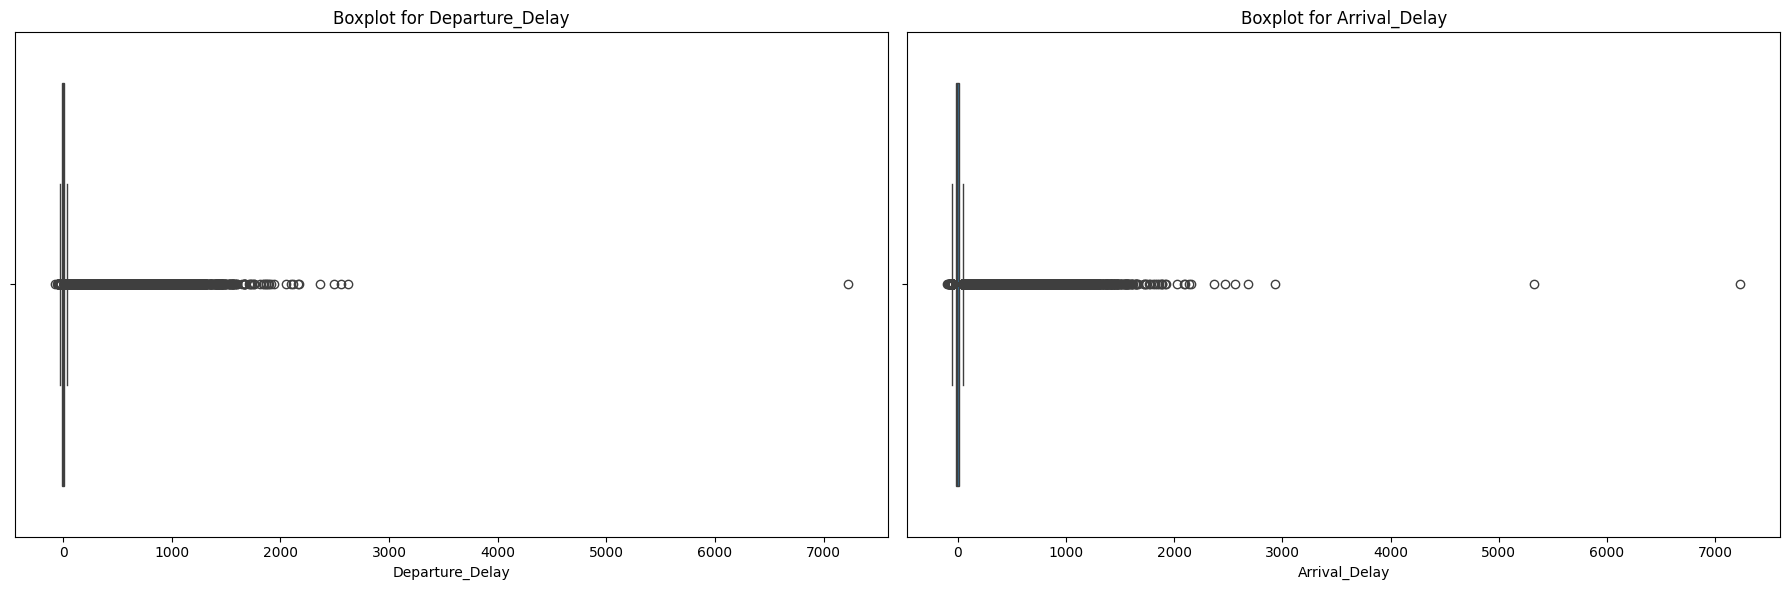

In [108]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=delays['Departure_Delay'])
plt.title('Boxplot for Departure_Delay')
plt.xlabel('Departure_Delay')

plt.subplot(1, 2, 2)
sns.boxplot(x=delays['Arrival_Delay'])
plt.title('Boxplot for Arrival_Delay')
plt.xlabel('Arrival_Delay')

plt.tight_layout()
plt.show()

In [109]:
value_counts = delays['Departure_Delay'].value_counts()
value_counts = value_counts.sort_index(ascending=False)
value_counts.head(50)

Departure_Delay
7223.21    1
2618.82    1
2555.93    1
2492.58    1
2366.01    1
2170.89    1
2160.55    1
2120.44    1
2100.94    1
2051.97    1
1946.25    1
1917.01    1
1898.05    1
1887.97    1
1872.09    1
1869.93    1
1852.21    1
1837.23    1
1811.95    1
1756.00    1
1754.38    1
1736.00    1
1726.03    1
1723.06    1
1715.87    1
1678.24    1
1673.00    1
1664.82    1
1663.22    1
1661.06    1
1644.66    1
1599.19    1
1599.06    1
1587.13    1
1586.03    1
1583.59    1
1568.85    1
1562.07    1
1561.49    1
1559.98    1
1558.97    1
1554.14    1
1552.00    1
1550.17    1
1540.31    1
1534.11    1
1532.45    1
1526.95    1
1523.90    1
1519.99    1
Name: count, dtype: int64

In [110]:
value_counts = delays['Arrival_Delay'].value_counts()
value_counts = value_counts.sort_index(ascending=False)
value_counts.head(50)

Arrival_Delay
7232.23    1
5323.70    1
2933.90    1
2677.78    1
2562.22    1
2473.65    1
2363.28    1
2150.69    1
2140.28    1
2098.12    1
2087.00    1
2028.98    1
1927.94    1
1918.98    1
1886.03    1
1882.79    1
1881.61    1
1859.03    1
1843.88    1
1817.80    1
1807.98    1
1771.95    1
1768.09    1
1740.14    1
1740.00    1
1721.01    1
1716.35    1
1663.92    1
1654.03    1
1648.01    1
1645.51    1
1643.36    1
1637.93    1
1619.88    1
1609.19    1
1606.93    1
1598.98    1
1597.64    1
1581.78    1
1578.24    1
1571.89    1
1569.10    1
1564.93    1
1562.95    1
1560.23    1
1556.79    1
1553.00    1
1550.08    1
1548.99    1
1541.15    1
Name: count, dtype: int64

In [112]:
delaytest = delays[delays['Departure_Delay'] > 1000]
delaytest[['Scheduled_Departure_Time', 'Actual_Departure_Time', 'Departure_Delay', 'Arrival_Delay', 'Scheduled_Minutes', 'Actual_Minutes']]

,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay,Arrival_Delay,Scheduled_Minutes,Actual_Minutes
708,1534,1736,1562.07,1550.08,934,1056
2122,952,621,1228.78,1236.12,592,381
9489,2255,1626,1051.09,1066.04,1375,986
12029,2059,1347,1007.98,1003.00,1259,827
15978,730,1407,1837.23,1817.80,450,847
...,...,...,...,...,...,...
1609744,715,634,1399.59,1440.24,435,394
1610326,1200,713,1153.05,1146.10,720,433
1612712,1927,1212,1005.26,988.92,1167,732
1620202,2320,1842,1161.98,1142.94,1400,1122


In [113]:
delays['test'] = round(delays['Departure_Delay'],0) - (delays['Actual_Minutes'] - delays['Scheduled_Minutes'])
check = delays['test'].value_counts()
check

test
0.00        1388649
-1.00         11646
1.00          11602
1440.00        7954
1439.00          68
1441.00          45
-1440.00         42
1380.00           7
2880.00           6
7200.00           1
-60.00            1
Name: count, dtype: int64

In [120]:
delaytest = delays[delays['test'] == -60]
delaytest

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,Departure_State,Arrival_State,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,key,Scheduled_Minutes,Actual_Minutes,test
1105263,7,3,13,105,712,AA,19805,1654,11292,11057.00,False,CO,NC,114.97,90.58,0,9.00,5.00,False,400,149.00,1337.00,29.61,15.93,15.66,23.46,0.10,0.10,AA_1654_11292_11057.0_7_105_712,65,240,-60.00


In [121]:
delays['Departure_Delay'] = delays.apply(
    lambda row: row['Departure_Delay'] + 60 if (row['test'] == -60) | (row['test'] == 1380) else row['Departure_Delay'], axis=1
)

delays['test'] = round(delays['Departure_Delay'],0) - (delays['Actual_Minutes'] - delays['Scheduled_Minutes'])
check = delays['test'].value_counts()
check

test
0.00        1388650
-1.00         11646
1.00          11602
1440.00        7961
1439.00          68
1441.00          45
-1440.00         42
2880.00           6
7200.00           1
Name: count, dtype: int64

In [122]:
value_counts = delays['Taxi_In_Time'].value_counts()
value_counts = value_counts.sort_index(ascending=False)
value_counts.head(50)

Taxi_In_Time
280.00    1
222.00    1
213.00    1
203.00    1
196.00    1
193.00    1
191.00    1
184.00    1
181.00    1
177.00    1
176.00    1
175.00    1
170.00    1
167.00    1
165.00    1
163.00    3
161.00    1
160.00    1
158.00    1
157.00    2
155.00    1
154.00    2
153.00    4
152.00    2
151.00    2
150.00    1
149.00    1
148.00    1
147.00    4
146.00    2
145.00    4
142.00    1
141.00    5
140.00    6
139.00    3
138.00    1
137.00    3
136.00    2
135.00    5
134.00    3
133.00    3
132.00    6
131.00    6
130.00    5
129.00    3
128.00    4
127.00    8
126.00    3
125.00    6
124.00    3
Name: count, dtype: int64

In [125]:
delaytest = delays[delays['Taxi_In_Time'] == 280]
delaytest

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,Departure_State,Arrival_State,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,key,Scheduled_Minutes,Actual_Minutes,test
1513970,1,6,27,1455,1626,AA,19805,3803,12339,10423.00,False,IN,TX,-7.58,269.80,0,14.00,280.00,False,1447,137.00,919.00,18.08,24.96,25.66,19.69,0.00,0.00,AA_3803_12339_10423.0_1_1455_1626,895,887,0.00


In [126]:
char_cols = delays.select_dtypes(include=['object'])
for col in char_cols:
    print(col, ':', char_cols[col].value_counts())

Marketing_Airline : Marketing_Airline
AA    361551
DL    297111
UA    257620
WN    256843
AS     78263
B6     53589
NK     44595
F9     30116
G4     25392
HA     14941
Name: count, dtype: int64
Departure_State : Departure_State
CA    148179
TX    147687
FL    124894
NY     78979
IL     77548
GA     70657
CO     63094
NC     62267
VA     57170
WA     42231
AZ     39436
NV     38255
MI     34350
PA     34308
NJ     30640
MA     28057
TN     27042
MN     26127
HI     25040
MO     23950
UT     23838
OH     19557
OR     17470
MD     17138
KY     14507
LA     14223
SC     13526
IN     11650
WI     11395
AK      8525
OK      7768
ID      7123
PR      6940
AL      6833
MT      5924
AR      5586
IA      5472
NE      5455
NM      5067
CT      4683
ND      3448
ME      3435
RI      3254
KS      3098
MS      3070
SD      2633
WY      2091
VT      1903
NH      1579
VI      1415
WV      1269
TT       224
DE        11
Name: count, dtype: int64
Arrival_State : Arrival_State
TX    148802
CA    148203
F

In [ ]:
df['Date'] = pd.to_datetime({'year': 2020,
                             'month': df['Month_number'],
                             'day': df['Day_number']})

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
temp_traffic = traffic[['date_time', 'traffic']]
temp_traffic['date_time'] = pd.to_datetime(temp_traffic['date_time'])
sns.lineplot(data=temp_traffic[:200],  palette="tab10", linewidth=2.5)